## 自动求导

PyTorch 中，所有神经网络的核心是 `autograd `包。autograd包为张量上的所有操作提供了自动求导机制。它是一个在运行时定义 ( define-by-run ）的框架，这意味着反向传播是根据代码如何运行来决定的，并且每次迭代可以是不同的。

`torch.Tensor `是这个包的核心类。如果设置它的属性` .requires_grad` 为 `True`，那么它将会追踪对于该张量的所有操作。当完成计算后可以通过调用` .backward()`，来自动计算所有的梯度。这个张量的所有梯度将会自动累加到`.grad`属性。

注意：在 y.backward() 时，如果 y 是标量，则不需要为 backward() 传入任何参数；否则，需要传入一个与 y 同形的Tensor。

要阻止一个张量被跟踪历史，可以调用` .detach() `方法将其与计算历史分离，并阻止它未来的计算记录被跟踪。为了防止跟踪历史记录(和使用内存），可以将代码块包装在 `with torch.no_grad(): `中。在评估模型时特别有用，因为模型可能具有 `requires_grad = True` 的可训练的参数，但是我们不需要在此过程中对他们进行梯度计算。

还有一个类对于`autograd`的实现非常重要：`Function`。`Tensor `和` Function` 互相连接生成了一个无环图 (acyclic graph)，它编码了完整的计算历史。每个张量都有一个` .grad_fn `属性，该属性引用了创建 `Tensor `自身的`Function`(除非这个张量是用户手动创建的，即这个张量的` grad_fn `是 `None` )。下面给出的例子中，张量由用户手动创建，因此grad_fn返回结果是None。

```python
x = torch.randn(3,3,requires_grad=True)
print(x.grad_fn)
```

```
None
```

如果需要计算导数，可以在 `Tensor` 上调用 `.backward()`。如果` Tensor` 是一个标量(即它包含一个元素的数据），则不需要为 `backward() `指定任何参数，但是如果它有更多的元素，则需要指定一个` gradient `参数，该参数是形状匹配的张量。

```python
import torch
```

创建一个张量并设置`requires_grad=True`用来追踪其计算历史

```python
x = torch.ones(2, 2, requires_grad=True)
print(x)
```

```
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
```

对这个张量做一次运算：

```python
y = x**2
print(y)
```

```
tensor([[1., 1.],
        [1., 1.]], grad_fn=<PowBackward0>)
```

`y`是计算的结果，所以它有`grad_fn`属性。

```python
print(y.grad_fn)
```

```
<PowBackward0 object at 0x7fb64d56cf70>
```

对 y 进行更多操作

```python
z = y * y * 3
out = z.mean()

print(z, out)
```

```
tensor([[3., 3.],
        [3., 3.]], grad_fn=<MulBackward0>) tensor(3., grad_fn=<MeanBackward0>)
```

`.requires_grad_(...) `原地改变了现有张量的` requires_grad `标志。如果没有指定的话，默认输入的这个标志是` False`。

```python
a = torch.randn(2, 2) # 缺失情况下默认 requires_grad = False
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)
```

```
False
True
<SumBackward0 object at 0x7f1b24845f98>
```

**梯度**

现在开始进行反向传播，因为` out` 是一个标量，因此` out.backward() `和` out.backward(torch.tensor(1.))` 等价。

```python
out.backward()
```

输出导数` d(out)/dx`

```python
print(x.grad)
```

数学上，若有向量函数$\vec{y}=f(\vec{x})$，那么 $\vec{y}$ 关于 $\vec{x}$ 的梯度就是一个雅可比矩阵：
$$
J=\left(\begin{array}{ccc}\frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}} \\ \vdots & \ddots & \vdots \\ \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}\end{array}\right)
$$
而 `torch.autograd` 这个包就是用来计算一些雅可比矩阵的乘积的。例如，如果 $v$ 是一个标量函数 $l = g(\vec{y})$ 的梯度：
$$
v=\left(\begin{array}{lll}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)
$$
由链式法则，我们可以得到：
$$
v J=\left(\begin{array}{lll}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)\left(\begin{array}{ccc}\frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}} \\ \vdots & \ddots & \vdots \\ \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}\end{array}\right)=\left(\begin{array}{lll}\frac{\partial l}{\partial x_{1}} & \cdots & \frac{\partial l}{\partial x_{n}}\end{array}\right)
$$


注意：grad在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零。

```python
# 再来反向传播⼀一次，注意grad是累加的
out2 = x.sum()
out2.backward()
print(x.grad)

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)
```

```
tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])
```

现在我们来看一个雅可比向量积的例子：

```python
x = torch.randn(3, requires_grad=True)
print(x)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i = i + 1
print(y)
print(i)
```

```
tensor([-0.3464, -0.1451,  1.6939], requires_grad=True)
tensor([-354.7274, -148.6218, 1734.5309], grad_fn=<MulBackward0>)
9
```

在这种情况下，`y `不再是标量。`torch.autograd` 不能直接计算完整的雅可比矩阵，但是如果我们只想要雅可比向量积，只需将这个向量作为参数传给 `backward：`

```python
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)
```

也可以通过将代码块包装在` with torch.no_grad():` 中，来阻止 autograd 跟踪设置了` .requires_grad=True `的张量的历史记录。

```python
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)
```

```
True
True
False
```

如果我们想要修改 tensor 的数值，但是又不希望被 autograd 记录(即不会影响反向传播)， 那么我们可以对 tensor.data 进行操作。

```python
x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播

y.backward()
print(x) # 更改data的值也会影响tensor的值 
print(x.grad)
```

```
tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])
```













In [2]:
import torch 
x = torch.randn(3,3,requires_grad=True)
print(x.grad_fn)

None


In [4]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [5]:
y = x**2
print(y)
print(y.grad_fn)
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[1., 1.],
        [1., 1.]], grad_fn=<PowBackward0>)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<MulBackward0>) tensor(3., grad_fn=<MeanBackward0>)


In [8]:
a = torch.randn(2, 2) # 缺失情况下默认 requires_grad = False
print(a)
a = ((a * 3) / (a - 1))
print(a)
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b)
print(b.grad_fn)

tensor([[ 1.1264,  0.9700],
        [ 0.7808, -0.6376]])
tensor([[ 26.7408, -97.0164],
        [-10.6834,   1.1680]])
False
True
tensor(10242.7510, grad_fn=<SumBackward0>)


In [9]:
# 再来反向传播⼀一次，注意grad是累加的
out2 = x.sum()
out2.backward()
print(out2)
print(x.grad)

out3 = x.sum()
x.grad.data.zero_()
print(out3)
out3.backward()
print(x.grad)

tensor(4., grad_fn=<SumBackward0>)
tensor([[1., 1.],
        [1., 1.]])
tensor(4., grad_fn=<SumBackward0>)
tensor([[1., 1.],
        [1., 1.]])


In [10]:
# 现在我们来看一个雅可比向量积的例子：

x = torch.randn(3, requires_grad=True)
print(x)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i = i + 1
print(y)
print(i)

tensor([-0.2743,  0.2623,  0.7204], requires_grad=True)
tensor([-561.7030,  537.2490, 1475.3563], grad_fn=<MulBackward0>)
10


In [12]:
# 在这种情况下，y不再是标量。torch.autograd 不能直接计算完整的雅可比矩阵，但是如果我们只想要雅可比向量积，只需将这个向量作为参数传给 backward：

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

# 也可以通过将代码块包装在with torch.no_grad(): 中，来阻止 autograd 跟踪设置了.requires_grad=True的张量的历史记录。

print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])
True
True
False


In [13]:
# 如果我们想要修改 tensor 的数值，但是又不希望被 autograd 记录(即不会影响反向传播)， 那么我们可以对 tensor.data 进行操作。

x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播

y.backward()
print(x) # 更改data的值也会影响tensor的值 
print(x.grad)

tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])


# 并行计算简介

在利用PyTorch做深度学习的过程中，可能会遇到数据量较大无法在单块GPU上完成，或者需要提升计算速度的场景，这时就需要用到并行计算。本节让我们来简单地了解一下并行计算的基本概念和主要实现方式，具体的内容会在课程的第二部分详细介绍。

#### 2.3.1  为什么要做并行计算

我们学习PyTorch的目的就是可以编写我们自己的框架，来完成特定的任务。可以说，在深度学习时代，GPU的出现让我们可以训练的更快，更好。所以，如何充分利用GPU的性能来提高我们模型学习的效果，这一技能是我们必须要学习的。这一节，我们主要讲的就是PyTorch的并行计算。PyTorch可以在编写完模型之后，让多个GPU来参与训练。

#### 2.3.2  CUDA是个啥

`CUDA`是我们使用GPU的提供商——NVIDIA提供的GPU并行计算框架。对于GPU本身的编程，使用的是`CUDA`语言来实现的。但是，在我们使用PyTorch编写深度学习代码时，使用的`CUDA`又是另一个意思。在PyTorch使用 `CUDA`表示要开始要求我们的模型或者数据开始使用GPU了。

在编写程序中，当我们使用了 `cuda()` 时，其功能是让我们的模型或者数据迁移到GPU当中，通过GPU开始计算。

#### 2.3.3  做并行的方法：

- **网络结构分布到不同的设备中(Network partitioning)**

在刚开始做模型并行的时候，这个方案使用的比较多。其中主要的思路是，将一个模型的各个部分拆分，然后将不同的部分放入到GPU来做不同任务的计算。其架构如下：

![模型并行.png](./figures/模型并行.png)

这里遇到的问题就是，不同模型组件在不同的GPU上时，GPU之间的传输就很重要，对于GPU之间的通信是一个考验。但是GPU的通信在这种密集任务中很难办到。所有这个方式慢慢淡出了视野，

- **同一层的任务分布到不同数据中**(**Layer-wise partitioning**)

第二种方式就是，同一层的模型做一个拆分，让不同的GPU去训练同一层模型的部分任务。其架构如下：

![拆分.png](./figures/拆分.png)

这样可以保证在不同组件之间传输的问题，但是在我们需要大量的训练，同步任务加重的情况下，会出现和第一种方式一样的问题。

- **不同的数据分布到不同的设备中，执行相同的任务(Data parallelism)**

第三种方式有点不一样，它的逻辑是，我不再拆分模型，我训练的时候模型都是一整个模型。但是我将输入的数据拆分。所谓的拆分数据就是，同一个模型在不同GPU中训练一部分数据，然后再分别计算一部分数据之后，只需要将输出的数据做一个汇总，然后再反传。其架构如下：

![数据并行.png](./figures/数据并行.png)

这种方式可以解决之前模式遇到的通讯问题。

**PS:现在的主流方式是数据并行的方式(Data parallelism)**

基本配置

首先导入必须的包。对于一个PyTorch项目，我们需要导入一些Python常用的包来帮助我们快速实现功能。常见的包有os、numpy等，此外还需要调用PyTorch自身一些模块便于灵活使用，比如torch、torch.nn、torch.utils.data.Dataset、torch.utils.data.DataLoader、torch.optimizer等等。注意这里只是建议导入的包导入的方式，可以采用不同的方案，比如涉及到表格信息的读入很可能用到pandas，对于不同的项目可能还需要导入一些更上层的包如cv2等。如果涉及可视化还会用到matplotlib、seaborn等。涉及到下游分析和指标计算也常用到sklearn。

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optimizer

根据前面我们对深度学习任务的梳理，有如下几个超参数可以统一设置，方便后续调试时修改：

    batch size
    初始学习率（初始）
    训练次数（max_epochs）
    GPU配置

batch_size = 16
lr = 1e-4
max_epochs = 100

GPU的设置有两种常见的方式：

#方案一：使用os.environ，这种情况如果使用GPU不需要设置
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

#方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

当然还会有一些其他模块或用户自定义模块会用到的参数，有需要也可以在一开始进行设置

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optimizer

### 数据读入

PyTorch数据读入是通过Dataset+DataLoader的方式完成的，Dataset定义好数据的格式和数据变换形式，DataLoader用iterative的方式不断读入批次数据。

我们可以定义自己的Dataset类来实现灵活的数据读取，定义的类需要继承PyTorch自身的Dataset类。主要包含三个函数：

- `__init__`: 用于向类中传入外部参数，同时定义样本集
- `__getitem__`: 用于逐个读取样本集合中的元素，可以进行一定的变换，并将返回训练/验证所需的数据
- `__len__`: 用于返回数据集的样本数

下面以cifar10数据集为例给出构建Dataset类的方式：

```python
train_data = datasets.ImageFolder(train_path, transform=data_transform)
val_data = datasets.ImageFolder(val_path, transform=data_transform)
```

这里使用了PyTorch自带的ImageFolder类的用于读取按一定结构存储的图片数据（path对应图片存放的目录，目录下包含若干子目录，每个子目录对应属于同一个类的图片）。

其中“data_transform”可以对图像进行一定的变换，如翻转、裁剪等操作，可自己定义。这里我们会在下一章通过实战加以介绍。

这里另外给出一个例子，其中图片存放在一个文件夹，另外有一个csv文件给出了图片名称对应的标签。这种情况下需要自己来定义Dataset类：

```python
class MyDataset(Dataset):
    def __init__(self, data_dir, info_csv, image_list, transform=None):
        """
        Args:
            data_dir: path to image directory.
            info_csv: path to the csv file containing image indexes
                with corresponding labels.
            image_list: path to the txt file contains image names to training/validation set
            transform: optional transform to be applied on a sample.
        """
        label_info = pd.read_csv(info_csv)
        image_file = open(image_list).readlines()
        self.data_dir = data_dir
        self.image_file = image_file
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_file[index].strip('\n')
        raw_label = self.label_info.loc[self.label_info['Image_index'] == image_name]
        label = raw_label.iloc[:,0]
        image_name = os.path.join(self.data_dir, image_name)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_file)
```

构建好Dataset后，就可以使用DataLoader来按批次读入数据了，实现代码如下：

```python
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4, shuffle=False)
```

其中:

- batch_size：样本是按“批”读入的，batch_size就是每次读入的样本数
- num_workers：有多少个进程用于读取数据
- shuffle：是否将读入的数据打乱
- drop_last：对于样本最后一部分没有达到批次数的样本，使其不再参与训练

这里可以看一下我们的加载的数据。PyTorch中的DataLoader的读取可以使用next和iter来完成

```python
import matplotlib.pyplot as plt
images, labels = next(iter(val_loader))
print(images.shape)
plt.imshow(images[0].transpose(1,2,0))
plt.show()
```

In [16]:
class MyDataset(Dataset):
    def __init__(self, data_dir, info_csv, image_list, transform=None):
        """
        Args:
            data_dir: path to image directory.
            info_csv: path to the csv file containing image indexes
                with corresponding labels.
            image_list: path to the txt file contains image names to training/validation set
            transform: optional transform to be applied on a sample.
        """
        label_info = pd.read_csv(info_csv)
        image_file = open(image_list).readlines()
        self.data_dir = data_dir
        self.image_file = image_file
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_file[index].strip('\n')
        raw_label = self.label_info.loc[self.label_info['Image_index'] == image_name]
        label = raw_label.iloc[:,0]
        image_name = os.path.join(self.data_dir, image_name)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_file)

In [20]:
# train_data = Dataset.ImageFolder(train_path, transform=data_transform)
# val_data = Dataset.ImageFolder(val_path, transform=data_transform)

In [21]:
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4, shuffle=True, drop_last=True)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4, shuffle=False)

In [22]:
# import matplotlib.pyplot as plt
# images, labels = next(iter(val_loader))
# print(images.shape)
# plt.imshow(images[0].transpose(1,2,0))
# plt.show()

##模型构建

#### 3.4.1  神经网络的构造

PyTorch中神经网络构造一般是基于 Module 类的模型来完成的，它让模型构造更加灵活。

Module 类是 nn 模块里提供的一个模型构造类，是所有神经⽹网络模块的基类，我们可以继承它来定义我们想要的模型。下面继承 Module 类构造多层感知机。这里定义的 MLP 类重载了 Module 类的 init 函数和 forward 函数。它们分别用于创建模型参数和定义前向计算。前向计算也即正向传播。

In [23]:
import torch
from torch import nn

class MLP(nn.Module):
  # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = nn.Linear(784, 256)
    self.act = nn.ReLU()
    self.output = nn.Linear(256,10)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.act(self.hidden(x))
    return self.output(o)

以上的 MLP 类中⽆须定义反向传播函数。系统将通过⾃动求梯度⽽自动⽣成反向传播所需的 backward 函数。

我们可以实例化 MLP 类得到模型变量 net 。下⾯的代码初始化 net 并传入输⼊数据 X 做一次前向计算。其中， net(X) 会调用 MLP 继承⾃自 Module 类的 __call__ 函数，这个函数将调⽤用 MLP 类定义的forward 函数来完成前向计算。


In [24]:
X = torch.rand(2,784)
net = MLP()
print(net)
net(X)

MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[ 0.0776,  0.0266, -0.1749, -0.1583,  0.1085, -0.0408, -0.2163,  0.1046,
         -0.0167, -0.0928],
        [ 0.1790,  0.1069, -0.1989, -0.0214,  0.1270, -0.0847, -0.3163,  0.1285,
         -0.0314, -0.1443]], grad_fn=<AddmmBackward>)

注意，这里并没有将 Module 类命名为 Layer (层)或者 Model (模型)之类的名字，这是因为该类是一个可供⾃由组建的部件。它的子类既可以是⼀个层(如PyTorch提供的 Linear 类)，⼜可以是一个模型(如这里定义的 MLP 类)，或者是模型的⼀个部分。

#### 3.4.2  神经网络中常见的层

深度学习的一个魅力在于神经网络中各式各样的层，例如全连接层、卷积层、池化层与循环层等等。虽然PyTorch提供了⼤量常用的层，但有时候我们依然希望⾃定义层。这里我们会介绍如何使用 Module 来自定义层，从而可以被反复调用。

- **不含模型参数的层**

我们先介绍如何定义一个不含模型参数的自定义层。下⾯构造的 MyLayer 类通过继承 Module 类自定义了一个**将输入减掉均值后输出**的层，并将层的计算定义在了 forward 函数里。这个层里不含模型参数。

In [25]:
import torch
from torch import nn

class MyLayer(nn.Module):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
    def forward(self, x):
        return x - x.mean() 

In [26]:
# 测试，实例化该层，然后做前向计算
layer = MyLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))

tensor([-2., -1.,  0.,  1.,  2.])

- **含模型参数的层**

我们还可以自定义含模型参数的自定义层。其中的模型参数可以通过训练学出。

Parameter 类其实是 Tensor 的子类，如果一 个 Tensor 是 Parameter ，那么它会⾃动被添加到模型的参数列表里。所以在⾃定义含模型参数的层时，我们应该将参数定义成 Parameter ，除了直接定义成 Parameter 类外，还可以使⽤ ParameterList 和 ParameterDict 分别定义参数的列表和字典。


In [29]:
class MyListDense(nn.Module):
    def __init__(self):
        super(MyListDense, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(4, 4)) for i in range(3)])
        self.params.append(nn.Parameter(torch.randn(4, 1)))

    def forward(self, x):
        for i in range(len(self.params)):
            x = torch.mm(x, self.params[i])
        return x
net = MyListDense()
print(net)

MyListDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 4x4]
      (1): Parameter containing: [torch.FloatTensor of size 4x4]
      (2): Parameter containing: [torch.FloatTensor of size 4x4]
      (3): Parameter containing: [torch.FloatTensor of size 4x1]
  )
)


In [28]:
class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = nn.ParameterDict({
                'linear1': nn.Parameter(torch.randn(4, 4)),
                'linear2': nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)

MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


下面给出常见的神经网络的一些层，比如卷积层、池化层，以及较为基础的AlexNet，LeNet等。

- **二维卷积层**

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。卷积层的模型参数包括了卷积核和标量偏差。在训练模型的时候，通常我们先对卷积核随机初始化，然后不断迭代卷积核和偏差。

In [30]:
import torch
from torch import nn

# 卷积运算（二维互相关）
def corr2d(X, K): 
    h, w = K.shape
    X, K = X.float(), K.float()
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

# 二维卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

卷积窗口形状为 $p \times q$ 的卷积层称为 $p \times q$  卷积层。同样，  $p \times q$ 卷积或 $p \times q$ 卷积核说明卷积核的高和宽分别为 $p$ 和 $q$。

填充(padding)是指在输⼊高和宽的两侧填充元素(通常是0元素)。

下面的例子里我们创建一个⾼和宽为3的二维卷积层，然后设输⼊高和宽两侧的填充数分别为1。给定一 个高和宽为8的输入，我们发现输出的高和宽也是8。


In [37]:
import torch
from torch import nn

# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    # (1, 1)代表批量大小和通道数
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
    # 排除不关心的前两维:批量和通道
    return Y.view(Y.shape[2:])

# 注意这里是两侧分别填充1⾏或列，所以在两侧一共填充2⾏或列
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3,padding=1)

X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [38]:
# 当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽。
# 使用高为5、宽为3的卷积核。在⾼和宽两侧的填充数分别为2和1
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [39]:
# 在二维互相关运算中，卷积窗口从输入数组的最左上方开始，按从左往右、从上往下 的顺序，依次在输⼊数组上滑动。我们将每次滑动的行数和列数称为步幅(stride)。
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])


填充可以增加输出的高和宽。这常用来使输出与输入具有相同的高和宽。

步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的 ( 为大于1的整数)。

- **池化层**

池化层每次对输入数据的一个固定形状窗口(⼜称池化窗口)中的元素计算输出。不同于卷积层里计算输⼊和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也 分别叫做最大池化或平均池化。在二维最⼤池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输⼊数组上滑动。当池化窗口滑动到某⼀位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

下面把池化层的前向计算实现在`pool2d`函数里。


In [40]:
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [41]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float)
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [42]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

我们可以使用`torch.nn`包来构建神经网络。我们已经介绍了`autograd`包，`nn`包则依赖于`autograd`包来定义模型并对它们求导。一个`nn.Module`包含各个层和一个`forward(input)`方法，该方法返回`output`。

#### 3.4.3  模型示例

- **LeNet**

![3.4.1](./figures/3.4.1.png)

这是一个简单的前馈神经网络 (feed-forward network）（LeNet）。它接受一个输入，然后将它送入下一层，一层接一层的传递，最后给出输出。

一个神经网络的典型训练过程如下：

1. 定义包含一些可学习参数(或者叫权重）的神经网络
2. 在输入数据集上迭代
3. 通过网络处理输入
4. 计算 loss (输出和正确答案的距离）
5. 将梯度反向传播给网络的参数
6. 更新网络的权重，一般使用一个简单的规则：`weight = weight - learning_rate * gradient`


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [44]:
# 我们只需要定义 `forward` 函数，`backward`函数会在使用`autograd`时自动定义，`backward`函数用来计算导数。我们可以在 `forward` 函数中使用任何针对张量的操作和计算。

# 一个模型的可学习参数可以通过`net.parameters()`返回

params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1的权重

10
torch.Size([6, 1, 5, 5])


In [45]:
# 让我们尝试一个随机的 32x32 的输入。注意:这个网络 (LeNet）的期待输入是 32x32 的张量。如果使用 MNIST 数据集来训练这个网络，要把图片大小重新调整到 32x32。

input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.1124, -0.1571,  0.1364, -0.0642, -0.0528, -0.1446, -0.0338, -0.1146,
          0.0769, -0.0177]], grad_fn=<AddmmBackward>)


In [46]:
# 清零所有参数的梯度缓存，然后进行随机梯度的反向传播：
net.zero_grad()
out.backward(torch.randn(1, 10))

注意：`torch.nn`只支持小批量处理 (mini-batches）。整个 `torch.nn` 包只支持小批量样本的输入，不支持单个样本的输入。比如，`nn.Conv2d` 接受一个4维的张量，即`nSamples x nChannels x Height x Width `如果是一个单独的样本，只需要使用`input.unsqueeze(0)` 来添加一个“假的”批大小维度。

- `torch.Tensor` - 一个多维数组，支持诸如`backward()`等的自动求导操作，同时也保存了张量的梯度。

- `nn.Module `- 神经网络模块。是一种方便封装参数的方式，具有将参数移动到GPU、导出、加载等功能。

- `nn.Parameter `- 张量的一种，当它作为一个属性分配给一个`Module`时，它会被自动注册为一个参数。

- `autograd.Function` - 实现了自动求导前向和反向传播的定义，每个`Tensor`至少创建一个`Function`节点，该节点连接到创建`Tensor`的函数并对其历史进行编码。

下面再介绍一个比较基础的案例AlexNet

- **AlexNet**

![3.4.2](./figures/3.4.2.png)

In [47]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [48]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

##损失函数

在深度学习广为使用的今天，我们可以在脑海里清晰的知道，一个模型想要达到很好的效果需要学习，也就是我们常说的训练。一个好的训练离不开优质的负反馈，这里的损失函数就是模型的负反馈。

![](./figures/3.5.1lossfunciton.png)

所以在PyTorch中，损失函数是必不可少的。它是数据输入到模型当中，产生的结果与真实标签的评价指标，我们的模型可以按照损失函数的目标来做出改进。

下面我们将开始探索pytorch的所拥有的损失函数。这里将列出PyTorch中常用的损失函数（一般通过torch.nn调用），并详细介绍每个损失函数的功能介绍、数学公式和调用代码。当然，PyTorch的损失函数还远不止这些，在解决实际问题的过程中需要进一步探索、借鉴现有工作，或者设计自己的损失函数。



#### 3.5.1  二分类交叉熵损失函数

```python
torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')
```

**功能**：计算二分类任务时的交叉熵（Cross Entropy）函数。在二分类中，label是{0,1}。对于进入交叉熵函数的input为概率分布的形式。一般来说，input为sigmoid激活层的输出，或者softmax的输出。

**主要参数**：

`weight`:每个类别的loss设置权值

`size_average`:数据为bool，为True时，返回的loss为平均值；为False时，返回的各样本的loss之和。

`reduce`:数据类型为bool，为True时，loss的返回是标量。

计算公式如下：
$$
\ell(x, y)=\left\{\begin{array}{ll}
\operatorname{mean}(L), & \text { if reduction }=\text { 'mean' } \\
\operatorname{sum}(L), & \text { if reduction }=\text { 'sum' }
\end{array}\right.
$$

In [58]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
print(input)
print(target)
output = loss(m(input), target)
output.backward()

tensor([0.7678, 1.0628, 2.0349], requires_grad=True)
tensor([0., 1., 0.])


In [50]:
print('BCELoss损失函数的计算结果为',output)

BCELoss损失函数的计算结果为 tensor(0.2666, grad_fn=<BinaryCrossEntropyBackward>)


#### 3.5.2  交叉熵损失函数

```python
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
```

**功能**：计算交叉熵函数

**主要参数**：  

`weight`:每个类别的loss设置权值。

`size_average`:数据为bool，为True时，返回的loss为平均值；为False时，返回的各样本的loss之和。

`ignore_index`:忽略某个类的损失函数。

`reduce`:数据类型为bool，为True时，loss的返回是标量。

计算公式如下：
$$
\operatorname{loss}(x, \text { class })=-\log \left(\frac{\exp (x[\text { class }])}{\sum_{j} \exp (x[j])}\right)=-x[\text { class }]+\log \left(\sum_{j} \exp (x[j])\right)
$$

In [57]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)
print(target)
output = loss(input, target)
output.backward()
print(output)

tensor([[ 0.5258,  0.1394,  0.8994,  0.0508, -1.1742],
        [ 0.5163,  1.2460, -1.1871, -1.8844,  0.7281],
        [ 0.4035,  0.3512, -0.1732,  0.2700, -0.9559]], requires_grad=True)
tensor([3, 1, 4])
tensor(1.7634, grad_fn=<NllLossBackward>)


#### 3.5.3  L1损失函数

```python
torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')
```

**功能：** 计算输出`y`和真实标签`target`之间的差值的绝对值。

我们需要知道的是，`reduction`参数决定了计算模式。有三种计算模式可选：none：逐个元素计算。
sum：所有元素求和，返回标量。
mean：加权平均，返回标量。 
如果选择`none`，那么返回的结果是和输入元素相同尺寸的。默认计算方式是求平均。

**计算公式如下：**
$$
L_{n} = |x_{n}-y_{n}|
$$

In [56]:
loss = nn.L1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
print(input)
print(target)
output = loss(input, target)
output.backward()
print('L1损失函数的计算结果为',output)

tensor([[-1.5000, -0.0690, -0.3350, -1.6670, -0.0905],
        [-0.7136,  0.4314,  1.2817, -0.9765, -1.1095],
        [ 0.2777, -0.0694,  1.2643, -0.0483,  0.2949]], requires_grad=True)
tensor([[-0.1159, -1.2980,  0.6128, -0.5248,  0.2209],
        [ 1.4999, -1.0349, -1.1215,  0.5327, -0.1730],
        [-0.8085,  0.9483, -0.8768, -1.8048, -0.0934]])
L1损失函数的计算结果为 tensor(1.3289, grad_fn=<L1LossBackward>)


#### 3.5.4  MSE损失函数
```python
torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
```
**功能：** 计算输出`y`和真实标签`target`之差的平方。

和`L1Loss`一样，`MSELoss`损失函数中，`reduction`参数决定了计算模式。有三种计算模式可选：none：逐个元素计算。
sum：所有元素求和，返回标量。默认计算方式是求平均。

**计算公式如下：**

$$
l_{n}=\left(x_{n}-y_{n}\right)^{2}
$$

In [54]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
print(input)
print(target)
output = loss(input, target)
output.backward()
print('MSE损失函数的计算结果为',output)

tensor([[ 0.1798, -0.0432,  0.2070, -0.6493,  1.3385],
        [-0.3960, -0.5431, -0.4457, -0.4783, -2.1990],
        [-0.4434,  0.3962,  1.4811,  0.3002, -1.8707]], requires_grad=True)
tensor([[-0.1060, -0.7905, -1.4250,  0.1494, -1.6710],
        [ 1.0123,  0.9307,  0.5518,  0.6348,  0.1266],
        [ 2.6338, -0.3374,  1.2583,  1.1947,  0.2921]])
MSE损失函数的计算结果为 tensor(2.6888, grad_fn=<MseLossBackward>)


#### 3.5.5  平滑L1 (Smooth L1)损失函数
```python
torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)
```
**功能：** L1的平滑输出，其功能是减轻离群点带来的影响

`reduction`参数决定了计算模式。有三种计算模式可选：none：逐个元素计算。
sum：所有元素求和，返回标量。默认计算方式是求平均。

**提醒：** 之后的损失函数中，关于`reduction` 这个参数依旧会存在。所以，之后就不再单独说明。

**计算公式如下：**
$$
\operatorname{loss}(x, y)=\frac{1}{n} \sum_{i=1}^{n} z_{i}
$$
其中，
$$
z_{i}=\left\{\begin{array}{ll}
0.5\left(x_{i}-y_{i}\right)^{2}, & \text { if }\left|x_{i}-y_{i}\right|<1 \\
\left|x_{i}-y_{i}\right|-0.5, & \text { otherwise }
\end{array}\right.
$$

In [55]:
loss = nn.SmoothL1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
print(input)
print(target)
output = loss(input, target)
output.backward()
print('SmoothL1Loss损失函数的计算结果为',output)

tensor([[-1.7672, -0.3196,  0.0947,  0.1789,  0.1324],
        [-1.0629, -1.0032,  0.3680, -0.7535, -0.9793],
        [ 0.4223,  0.1438,  0.0963,  0.9450, -0.8456]], requires_grad=True)
tensor([[-0.4131,  0.6129,  2.1607,  1.7367,  0.0192],
        [-1.7636, -0.7424, -2.0905, -0.2236, -0.1123],
        [-0.0560,  0.3320, -0.0105,  1.0980, -0.9615]])
SmoothL1Loss损失函数的计算结果为 tensor(0.4553, grad_fn=<SmoothL1LossBackward>)


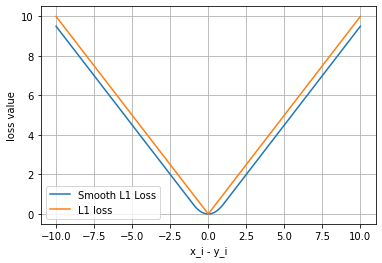

In [59]:
# **平滑L1与L1的对比**
# 这里我们通过可视化两种损失函数曲线来对比平滑L1和L1两种损失函数的区别。

inputs = torch.linspace(-10, 10, steps=5000)
target = torch.zeros_like(inputs)

loss_f_smooth = nn.SmoothL1Loss(reduction='none')
loss_smooth = loss_f_smooth(inputs, target)
loss_f_l1 = nn.L1Loss(reduction='none')
loss_l1 = loss_f_l1(inputs,target)

plt.plot(inputs.numpy(), loss_smooth.numpy(), label='Smooth L1 Loss')
plt.plot(inputs.numpy(), loss_l1, label='L1 loss')
plt.xlabel('x_i - y_i')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()

可以看出，对于`smoothL1`来说，在 0 这个尖端处，过渡更为平滑。

#### 3.5.6  目标泊松分布的负对数似然损失
```python
torch.nn.PoissonNLLLoss(log_input=True, full=False, size_average=None, eps=1e-08, reduce=None, reduction='mean')
```
**功能：** 泊松分布的负对数似然损失函数

**主要参数：**

`log_input`：输入是否为对数形式，决定计算公式。

`full`：计算所有 loss，默认为 False。

`eps`：修正项，避免 input 为 0 时，log(input) 为 nan 的情况。

**数学公式：**

- 当参数`log_input=True`：
$$
\operatorname{loss}\left(x_{n}, y_{n}\right)=e^{x_{n}}-x_{n} \cdot y_{n}
$$


- 当参数`log_input=False`：

    $$
    \operatorname{loss}\left(x_{n}, y_{n}\right)=x_{n}-y_{n} \cdot \log \left(x_{n}+\text { eps }\right)
    $$
    

In [61]:
loss = nn.PoissonNLLLoss()
log_input = torch.randn(5, 2, requires_grad=True)
target = torch.randn(5, 2)
print(input)
print(target)
output = loss(log_input, target)
output.backward()

print('PoissonNLLLoss损失函数的计算结果为',output)

tensor([0.7678, 1.0628, 2.0349], requires_grad=True)
tensor([[ 0.4237,  0.2304],
        [-1.1830, -0.9445],
        [-0.3609,  1.4539],
        [-1.3601,  2.1541],
        [ 1.5953,  0.4600]])
PoissonNLLLoss损失函数的计算结果为 tensor(2.1622, grad_fn=<MeanBackward0>)


#### 3.5.7  KL散度
```python
torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
```
**功能：** 计算KL散度，也就是计算相对熵。用于连续分布的距离度量，并且对离散采用的连续输出空间分布进行回归通常很有用。

**主要参数:** 

`reduction`：计算模式，可为 `none`/`sum`/`mean`/`batchmean`。

    none：逐个元素计算。
    
    sum：所有元素求和，返回标量。
    
    mean：加权平均，返回标量。
    
    batchmean：batchsize 维度求平均值。

**计算公式：**

$$
\begin{aligned}
D_{\mathrm{KL}}(P, Q)=\mathrm{E}_{X \sim P}\left[\log \frac{P(X)}{Q(X)}\right] &=\mathrm{E}_{X \sim P}[\log P(X)-\log Q(X)] \\
&=\sum_{i=1}^{n} P\left(x_{i}\right)\left(\log P\left(x_{i}\right)-\log Q\left(x_{i}\right)\right)
\end{aligned}
$$

In [62]:
inputs = torch.tensor([[0.5, 0.3, 0.2], [0.2, 0.3, 0.5]])
target = torch.tensor([[0.9, 0.05, 0.05], [0.1, 0.7, 0.2]], dtype=torch.float)
print(inputs)
print(target)
loss = nn.KLDivLoss()
output = loss(inputs,target)

print('KLDivLoss损失函数的计算结果为',output)

tensor([[0.5000, 0.3000, 0.2000],
        [0.2000, 0.3000, 0.5000]])
tensor([[0.9000, 0.0500, 0.0500],
        [0.1000, 0.7000, 0.2000]])
KLDivLoss损失函数的计算结果为 tensor(-0.3335)


/home/googler/.local/lib/python3.8/site-packages/torch/nn/functional.py:2741: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


#### 3.5.8  MarginRankingLoss
```python
torch.nn.MarginRankingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')
```
**功能：** 计算两个向量之间的相似度，用于排序任务。该方法用于计算两组数据之间的差异。

**主要参数:** 

`margin`：边界值，$$x_{1}$$ 与$$x_{2}$$ 之间的差异值。

`reduction`：计算模式，可为 none/sum/mean。

**计算公式：**

$$
\operatorname{loss}(x 1, x 2, y)=\max (0,-y *(x 1-x 2)+\operatorname{margin})
$$

In [63]:
loss = nn.MarginRankingLoss()
input1 = torch.randn(3, requires_grad=True)
input2 = torch.randn(3, requires_grad=True)
target = torch.randn(3).sign()
print(input1, input2, target)
output = loss(input1, input2, target)
output.backward()

print('MarginRankingLoss损失函数的计算结果为',output)

tensor([-1.4080, -0.0435,  1.0979], requires_grad=True) tensor([-0.3391,  0.4939,  1.9473], requires_grad=True) tensor([-1., -1., -1.])
MarginRankingLoss损失函数的计算结果为 tensor(0., grad_fn=<MeanBackward0>)


#### 3.5.9  多标签边界损失函数
```python
torch.nn.MultiLabelMarginLoss(size_average=None, reduce=None, reduction='mean')
```

**功能：** 对于多标签分类问题计算损失函数。

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

**计算公式：**
$$
\operatorname{loss}(x, y)=\sum_{i j} \frac{\max (0,1-x[y[j]]-x[i])}{x \cdot \operatorname{size}(0)}
$$

$$
\begin{array}{l}
\text { 其中, } i=0, \ldots, x \cdot \operatorname{size}(0), j=0, \ldots, y \cdot \operatorname{size}(0), \text { 对于所有的 } i \text { 和 } j \text {, 都有 } y[j] \geq 0 \text { 并且 }\\
i \neq y[j]
\end{array}
$$

In [64]:
loss = nn.MultiLabelMarginLoss()
x = torch.FloatTensor([[0.9, 0.2, 0.4, 0.8]])
# for target y, only consider labels 3 and 0, not after label -1
y = torch.LongTensor([[3, 0, -1, 1]])# 真实的分类是，第3类和第0类
print(x, y)
output = loss(x, y)

print('MultiLabelMarginLoss损失函数的计算结果为',output)

tensor([[0.9000, 0.2000, 0.4000, 0.8000]]) tensor([[ 3,  0, -1,  1]])
MultiLabelMarginLoss损失函数的计算结果为 tensor(0.4500)



#### 3.5.10  二分类损失函数
```python
torch.nn.SoftMarginLoss(size_average=None, reduce=None, reduction='mean')torch.nn.(size_average=None, reduce=None, reduction='mean')
```
**功能：** 计算二分类的 logistic 损失。

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

**计算公式：**

$$
\operatorname{loss}(x, y)=\sum_{i} \frac{\log (1+\exp (-y[i] \cdot x[i]))}{x \cdot \operatorname{nelement}()}
$$

$$
\
\text { 其中, } x . \text { nelement() 为输入 } x \text { 中的样本个数。注意这里 } y \text { 也有 } 1 \text { 和 }-1 \text { 两种模式。 }
\
$$

In [65]:
inputs = torch.tensor([[0.3, 0.7], [0.5, 0.5]])  # 两个样本，两个神经元
target = torch.tensor([[-1, 1], [1, -1]], dtype=torch.float)  # 该 loss 为逐个神经元计算，需要为每个神经元单独设置标签
print(inputs, target)
loss_f = nn.SoftMarginLoss()
output = loss_f(inputs, target)

print('SoftMarginLoss损失函数的计算结果为',output)

tensor([[0.3000, 0.7000],
        [0.5000, 0.5000]]) tensor([[-1.,  1.],
        [ 1., -1.]])
SoftMarginLoss损失函数的计算结果为 tensor(0.6764)


#### 3.5.11  多分类的折页损失
```python
torch.nn.MultiMarginLoss(p=1, margin=1.0, weight=None, size_average=None, reduce=None, reduction='mean')
```
**功能：** 计算多分类的折页损失

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

`p：`可选 1 或 2。

`weight`：各类别的 loss 设置权值。

`margin`：边界值


**计算公式：**

$$
\operatorname{loss}(x, y)=\frac{\sum_{i} \max (0, \operatorname{margin}-x[y]+x[i])^{p}}{x \cdot \operatorname{size}(0)}
$$

$$
\begin{array}{l}
\text { 其中, } x \in\{0, \ldots, x \cdot \operatorname{size}(0)-1\}, y \in\{0, \ldots, y \cdot \operatorname{size}(0)-1\} \text {, 并且对于所有的 } i \text { 和 } j \text {, }\\
\text { 都有 } 0 \leq y[j] \leq x \cdot \operatorname{size}(0)-1, \text { 以及 } i \neq y[j] \text { 。 }
\end{array}
$$

In [66]:
inputs = torch.tensor([[0.3, 0.7], [0.5, 0.5]]) 
target = torch.tensor([0, 1], dtype=torch.long) 

loss_f = nn.MultiMarginLoss()
output = loss_f(inputs, target)
print(inputs ,target)
print('MultiMarginLoss损失函数的计算结果为',output)

tensor([[0.3000, 0.7000],
        [0.5000, 0.5000]]) tensor([0, 1])
MultiMarginLoss损失函数的计算结果为 tensor(0.6000)


#### 3.5.12  三元组损失

```python
torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, size_average=None, reduce=None, reduction='mean')
```
**功能：** 计算三元组损失。

**三元组:** 这是一种数据的存储或者使用格式。<实体1，关系，实体2>。在项目中，也可以表示为< `anchor`, `positive examples` , `negative examples`>

在这个损失函数中，我们希望去`anchor`的距离更接近`positive examples`，而远离`negative examples `

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

`p：`可选 1 或 2。


`margin`：边界值


**计算公式：**

$$
L(a, p, n)=\max \left\{d\left(a_{i}, p_{i}\right)-d\left(a_{i}, n_{i}\right)+\operatorname{margin}, 0\right\}
$$

$$
\text { 其中, } d\left(x_{i}, y_{i}\right)=\left\|\mathbf{x}_{i}-\mathbf{y}_{i}\right\|_{\text {・ }}
$$


In [67]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
print(anchor, positive, negative)
output = triplet_loss(anchor, positive, negative)
output.backward()
print('TripletMarginLoss损失函数的计算结果为',output)

tensor([[-0.3521, -1.2300,  0.1997,  ...,  0.1583, -0.7949,  0.1089],
        [-1.7695, -0.6294,  1.6083,  ..., -0.1657,  0.1117,  0.0486],
        [-0.9730, -0.6594,  0.3879,  ...,  0.7471,  0.2908, -0.7662],
        ...,
        [-0.2888, -0.9644, -0.7746,  ..., -0.6941,  0.4096, -1.2438],
        [ 0.7742,  1.2561,  1.9119,  ..., -0.7570,  0.4977,  0.2828],
        [-2.4217, -0.4717,  1.1052,  ...,  0.8187,  0.7275,  0.8578]],
       requires_grad=True) tensor([[-0.1668, -0.5596, -0.3265,  ...,  0.6739,  1.2366, -1.5409],
        [ 0.8056, -2.0447,  0.2014,  ..., -0.0702, -0.9089,  0.6037],
        [-1.1150, -0.1481,  1.0329,  ..., -0.0888,  1.3931,  0.7356],
        ...,
        [ 0.1900,  0.0067,  0.4947,  ..., -0.0135, -0.3680, -0.0849],
        [ 1.0514, -0.4749,  0.5712,  ...,  1.1862,  1.8020, -0.2368],
        [ 1.1421, -0.9168, -1.0399,  ..., -1.0033,  0.9503, -1.3986]],
       requires_grad=True) tensor([[-0.4625,  0.7936, -0.7085,  ..., -0.5274,  0.2260, -0.4715],
        

#### 3.5.13  HingEmbeddingLoss
```python
torch.nn.HingeEmbeddingLoss(margin=1.0, size_average=None, reduce=None, reduction='mean')
```
**功能：** 对输出的embedding结果做Hing损失计算

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。



`margin`：边界值


**计算公式：**

$$
l_{n}=\left\{\begin{array}{ll}
x_{n}, & \text { if } y_{n}=1 \\
\max \left\{0, \Delta-x_{n}\right\}, & \text { if } y_{n}=-1
\end{array}\right.
$$
**注意事项：** 输入x应为两个输入之差的绝对值。

可以这样理解，让个输出的是正例yn=1,那么loss就是x，如果输出的是负例y=-1，那么输出的loss就是要做一个比较。


In [68]:
loss_f = nn.HingeEmbeddingLoss()
inputs = torch.tensor([[1., 0.8, 0.5]])
target = torch.tensor([[1, 1, -1]])
print(inputs, target)
output = loss_f(inputs,target)

print('HingEmbeddingLoss损失函数的计算结果为',output)

tensor([[1.0000, 0.8000, 0.5000]]) tensor([[ 1,  1, -1]])
HingEmbeddingLoss损失函数的计算结果为 tensor(0.7667)


#### 3.5.14  余弦相似度
```python
torch.nn.CosineEmbeddingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')
```
**功能：** 对两个向量做余弦相似度

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。



`margin`：可取值[-1,1] ，推荐为[0,0.5] 。


**计算公式：**

$$
\operatorname{loss}(x, y)=\left\{\begin{array}{ll}
1-\cos \left(x_{1}, x_{2}\right), & \text { if } y=1 \\
\max \left\{0, \cos \left(x_{1}, x_{2}\right)-\text { margin }\right\}, & \text { if } y=-1
\end{array}\right.
$$
其中,
$$
\cos (\theta)=\frac{A \cdot B}{\|A\|\|B\|}=\frac{\sum_{i=1}^{n} A_{i} \times B_{i}}{\sqrt{\sum_{i=1}^{n}\left(A_{i}\right)^{2}} \times \sqrt{\sum_{i=1}^{n}\left(B_{i}\right)^{2}}}
$$


这个损失函数应该是最广为人知的。对于两个向量，做余弦相似度。将余弦相似度作为一个距离的计算方式，如果两个向量的距离近，则损失函数值小，反之亦然。


In [79]:
# loss_f = nn.CosineEmbeddingLoss()
# inputs_1 = torch.tensor([[0.3, 0.5, 0.7], [0.3, 0.5, 0.7]])
# inputs_2 = torch.tensor([[0.1, 0.3, 0.5], [0.1, 0.3, 0.5]])
# target = torch.tensor([[1, -1]], dtype=torch.float)
# # print(inputs_1, inputs_2, target)
# output = loss_f(inputs_1, inputs_2, target)

# nn.CosineEmbeddingLoss()

# print('CosineEmbeddingLoss损失函数的计算结果为',output)

#### 3.5.15  CTC损失函数
```python
torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=False)
```
**功能：** 用于解决时序类数据的分类

计算连续时间序列和目标序列之间的损失。CTCLoss对输入和目标的可能排列的概率进行求和，产生一个损失值，这个损失值对每个输入节点来说是可分的。输入与目标的对齐方式被假定为 "多对一"，这就限制了目标序列的长度，使其必须是≤输入长度。

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。


`blank`：blank label。


`zero_infinity`：无穷大的值或梯度值为 


In [74]:
# Target are to be padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()


# Target are to be un-padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

# Initialize random batch of targets (0 = blank, 1:C = classes)
target_lengths = torch.randint(low=1, high=T, size=(N,), dtype=torch.long)
target = torch.randint(low=1, high=C, size=(sum(target_lengths),), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

print('CTCLoss损失函数的计算结果为',loss)

CTCLoss损失函数的计算结果为 tensor(28.6589, grad_fn=<MeanBackward0>)


#### 3.6.2  Pytorch提供的优化器

Pytorch很人性化的给我们提供了一个优化器的库torch.optim，在这里面提供了十种优化器。

+ torch.optim.ASGD
+ torch.optim.Adadelta
+ torch.optim.Adagrad
+ torch.optim.Adam
+ torch.optim.AdamW
+ torch.optim.Adamax
+ torch.optim.LBFGS
+ torch.optim.RMSprop
+ torch.optim.Rprop
+ torch.optim.SGD
+ torch.optim.SparseAdam

而以上这些优化算法均继承于`Optimizer`，下面我们先来看下所有优化器的基类`Optimizer`。定义如下：


In [77]:
class Optimizer(object):
    def __init__(self, params, defaults):        
        self.defaults = defaults
        self.state = defaultdict(dict)
        self.param_groups = []

**`Optimizer`有三个属性：**

+ `defaults`：存储的是优化器的超参数，例子如下：

```python
{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}
```

+ `state`：参数的缓存，例子如下：

```python
defaultdict(<class 'dict'>, {tensor([[ 0.3864, -0.0131],
        [-0.1911, -0.4511]], requires_grad=True): {'momentum_buffer': tensor([[0.0052, 0.0052],
        [0.0052, 0.0052]])}})
```

+ `param_groups`：管理的参数组，是一个list，其中每个元素是一个字典，顺序是params，lr，momentum，dampening，weight_decay，nesterov，例子如下：

```python
[{'params': [tensor([[-0.1022, -1.6890],[-1.5116, -1.7846]], requires_grad=True)], 'lr': 1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]
```

**`Optimizer`还有以下的方法：**

+ `zero_grad()`：清空所管理参数的梯度，PyTorch的特性是张量的梯度不自动清零，因此每次反向传播后都需要清空梯度。


In [78]:
def zero_grad(self, set_to_none: bool = False):
    for group in self.param_groups:
        for p in group['params']:
            if p.grad is not None:  #梯度不为空
                if set_to_none: 
                    p.grad = None
                else:
                    if p.grad.grad_fn is not None:
                        p.grad.detach_()
                    else:
                        p.grad.requires_grad_(False)
                    p.grad.zero_()# 梯度设置为0

In [88]:
import os
import torch

# 设置权重，服从正态分布  --> 2 x 2
weight = torch.randn((2, 2), requires_grad=True)
# 设置梯度为全1矩阵  --> 2 x 2
weight.grad = torch.ones((2, 2))
# 输出现有的weight和data
print("The data of weight before step:\n{}".format(weight.data))
print("The grad of weight before step:\n{}".format(weight.grad))
# 实例化优化器
optimizer = torch.optim.SGD([weight], lr=0.1, momentum=0.9)
# 进行一步操作
optimizer.step()
# 查看进行一步后的值，梯度
print("The data of weight after step:\n{}".format(weight.data))
print("The grad of weight after step:\n{}".format(weight.grad))
# 权重清零
optimizer.zero_grad()
# 检验权重是否为0
print("The grad of weight after optimizer.zero_grad():\n{}".format(weight.grad))
# 输出参数
print("optimizer.params_group is \n{}".format(optimizer.param_groups))
# 查看参数位置，optimizer和weight的位置一样，我觉得这里可以参考Python是基于值管理
print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))
# 添加参数：weight2
weight2 = torch.randn((3, 3), requires_grad=True)
optimizer.add_param_group({"params": weight2, 'lr': 0.0001, 'nesterov': True})
# 查看现有的参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
# 查看当前状态信息
opt_state_dict = optimizer.state_dict()
print("state_dict before step:\n", opt_state_dict)
# 进行5次step操作
for _ in range(50):
    optimizer.step()
# 输出现有状态信息
print("state_dict after step:\n", optimizer.state_dict())
# 保存参数信息
torch.save(optimizer.state_dict(),os.path.join(r"./", "optimizer_state_dict.pkl"))
print("----------done-----------")
# 加载参数信息
state_dict = torch.load(r"./optimizer_state_dict.pkl") # 需要修改为你自己的路径
optimizer.load_state_dict(state_dict)
print("load state_dict successfully\n{}".format(state_dict))
# 输出最后属性信息
print("\n{}".format(optimizer.defaults))
print("\n{}".format(optimizer.state))
print("\n{}".format(optimizer.param_groups))

The data of weight before step:
tensor([[-0.6408,  0.4553],
        [-0.6091,  0.3922]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])
The data of weight after step:
tensor([[-0.7408,  0.3553],
        [-0.7091,  0.2922]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])
The grad of weight after optimizer.zero_grad():
tensor([[0., 0.],
        [0., 0.]])
optimizer.params_group is 
[{'params': [tensor([[-0.7408,  0.3553],
        [-0.7091,  0.2922]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]
weight in optimizer:140360452351296
weight in weight:140360452351296

optimizer.param_groups is
[{'params': [tensor([[-0.7408,  0.3553],
        [-0.7091,  0.2922]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}, {'params': [tensor([[ 0.5173,  0.0395,  0.0376],
        [-1.1254,  0.5430, -0.5823],
        [ 0.7650, -1.3181, -2.3473]], requ

#### 3.6.5  实验

为了更好的帮大家了解优化器，我们对PyTorch中的优化器进行了一个小测试

**数据生成**：

In [83]:
a = torch.linspace(-1, 1, 1000)
# 升维操作
x = torch.unsqueeze(a, dim=1)
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(x.size()))

In [87]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(1, 20)
        self.predict = nn.Linear(20, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.predict(x)
        return x

下面这部分是测试图，纵坐标代表Loss，横坐标代表的是Step：

![](./figures/3.6.2.png)

在上面的图片上，曲线下降的趋势和对应的steps代表了在这轮数据，模型下的收敛速度

**注意:**

优化器的选择是需要根据模型进行改变的，不存在绝对的好坏之分，我们需要多进行一些测试。

后续会添加SparseAdam，LBFGS这两个优化器的可视化结果


### 训练和评估

完成了上述设定后就可以加载数据开始训练模型了。首先应该设置模型的状态：如果是训练状态，那么模型的参数应该支持反向传播的修改；如果是验证/测试状态，则不应该修改模型参数。在PyTorch中，模型的状态设置非常简便，如下的两个操作二选一即可：

```python
model.train()   # 训练状态
model.eval()   # 验证/测试状态
```

我们前面在DataLoader构建完成后介绍了如何从中读取数据，在训练过程中使用类似的操作即可，区别在于此时要用for循环读取DataLoader中的全部数据。

```python
for data, label in train_loader:
```

之后将数据放到GPU上用于后续计算，此处以.cuda()为例

```python
data, label = data.cuda(), label.cuda()
```

开始用当前批次数据做训练时，应当先将优化器的梯度置零：

```python
optimizer.zero_grad()
```

之后将data送入模型中训练：

```python
output = model(data)
```

根据预先定义的criterion计算损失函数：

```python
loss = criterion(output, label)
```

将loss反向传播回网络：

```python
loss.backward()
```

使用优化器更新模型参数：

```python
optimizer.step()
```

这样一个训练过程就完成了，后续还可以计算模型准确率等指标，这部分会在下一节的图像分类实战中加以介绍。

验证/测试的流程基本与训练过程一致，不同点在于：

- 需要预先设置torch.no_grad，以及将model调至eval模式
- 不需要将优化器的梯度置零
- 不需要将loss反向回传到网络
- 不需要更新optimizer

一个完整的训练过程如下所示：

In [89]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(label, output)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [90]:
# 对应的，一个完整的验证过程如下所示：
def val(epoch):       
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
            running_accu += torch.sum(preds == label.data)
    val_loss = val_loss/len(val_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, val_loss))